In [33]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from sklearn import tree
from sklearn.tree            import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics         import mean_squared_error
from sklearn.ensemble import BaggingRegressor
os.chdir("C:/dev/python")
os.getcwd()

'C:\\dev\\python'

# Tree-based methods, bagging e boosting

## Definição: Árvore
Um grafo $\mathcal{G}=(E,V)$ é uma árvore se é direcionado, acíclico e conexo. 

- Direcionado: Existe um fluxo correto no qual andamos.
- Acíclico: Não podemos dar voltas, como $a\to b\to c \to a$.
- Conexo: Existem caminhos entre todos os vértices.

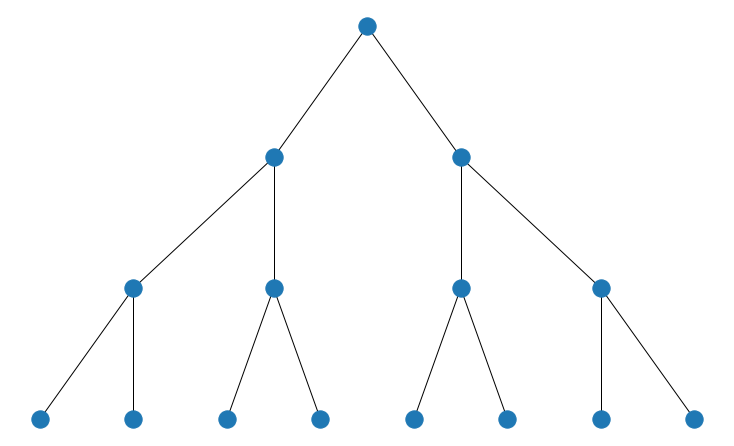

In [196]:
plt.rcParams['figure.figsize'] = 10,6
import matplotlib.pyplot as plt
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
T   = nx.balanced_tree(2, 3)
pos = graphviz_layout(T, prog="dot")
nx.draw(T, pos)
plt.show()

## Árvores de decisão

Uma árvore de decisão é uma árvore cujas folhas foram determinadas por um critério estatístico. O ajuste de uma árvore ocorre da seguinte maneira:

1. Iniciamos com um único vértice, a raíz, contendo todas as observações.
2. Calculamos um critério de impureza para todas as variáveis disponiveis, como as somas de quadrados

$$
RSS(\mathbf{y}) = \sum_{i \in G_1} (y_i - \bar{y}) + \sum_{i \in G_2} (y_i - \bar{y})
$$

tal que $G_1$ e $G_2$ são definidos por alguma regra do tipo $x_k < \alpha$ e $\alpha$ é o parâmetro a ser definido, isto é,

$$
\hat{\alpha} = \arg\min_{k\in\mathbb{R}} RSS(k;\mathbf{y})
$$

3. Entre todas as covariáveis escolhemos o par $(x_k, \alpha_k)$ que dá o menor critério de impureza.

4. Repetimos os passos 3-4 até atingirmos algum critério de parada.

Esse método de ajuste é chamado de recursive binary splitting.

No caso de classficação, as seguintes funções de impureza são frequentemente utilizadas. Seja $m$ o vértice que estamos analisando e $\{1,\dots,K\}$ as classes disponiveis, podemos definir as funções como a seguir

- Entropia cruzada:
$$
-\sum_{k=1}^K p_{mk}\log(p_{mk})
$$

- GINI:
$$
\sum_{k=1}^K p_{mk}(1-p_{mk})
$$

In [3]:
hitters = pd.read_csv("Hitters.csv").dropna()
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [34]:
y = hitters[["Salary"]]
X = hitters[["Hits", "Years"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=0)

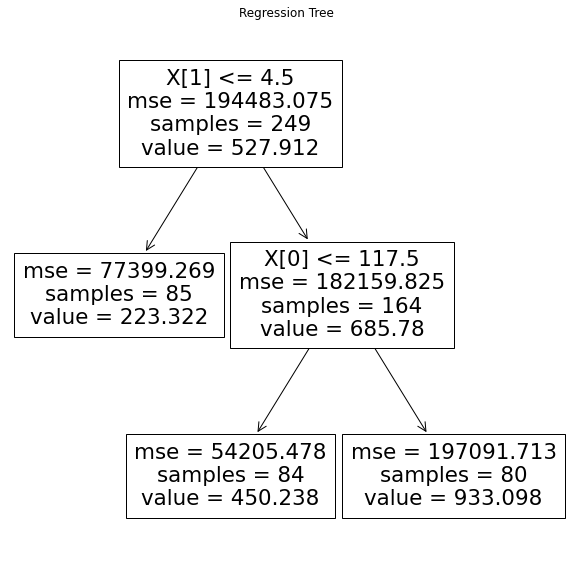

In [36]:
hitTree = tree.DecisionTreeRegressor(max_depth=2,min_samples_split=100,min_samples_leaf=0.1)
hitTree.fit(X=X_train, y=y_train)
plt.rcParams['figure.figsize'] = 10,10
plt.figure()
tree.plot_tree(hitTree)
plt.title("Regression Tree")
plt.show()
y_pred = hitTree.predict(X_test)

In [37]:
mean_squared_error(y_test, y_pred)

227062.9544491668

Text(0.5, 1.0, 'Partição gerada pelo modelo')

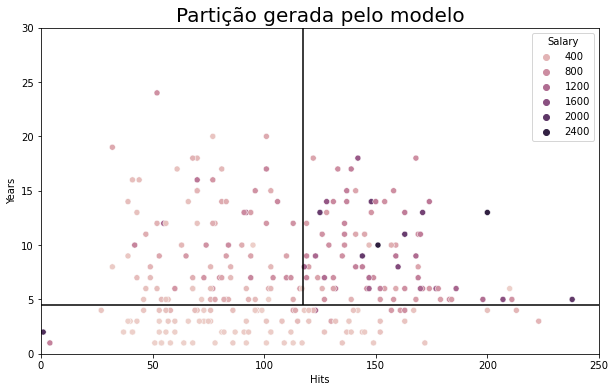

In [183]:
plt.rcParams['figure.figsize'] = 10,6
scatter = sb.scatterplot(data=hitters, x="Hits", y="Years",hue="Salary")
scatter.hlines(y=4.5,  xmin=0,  xmax=250,colors='black')
scatter.vlines(x=117.5,ymin=4.5,ymax=140,colors='black')
scatter.set(ylim=(0, 30),xlim=(0,250))
scatter.set_title("Partição gerada pelo modelo",fontsize=20)

## Cost complexity pruning

O uso de um critério de impureza irrestrito frequentemente causa overfitting. As árvores serão extremamente profundas (tree depth) e alguma forma de poda é necessária para diminuir a variância do preditor. Uma maneira intuitiva e que detém boas propriedades é adicionar um parâmetro de penalização ao tamanho da árvore,

$$
\sum_{m=1}^{|T|} \sum_{x_i\in R_m}(y_i - \bar{y}_{R_{m}}) + \lambda|T|
$$
tal que $\lambda$ é o parâmetro de penalização e $|T|$ é o número de folhas (vértices terminais) na árvore.

Resultados teóricas garantem que a media que $\lambda$ aumenta, as árvores ótimas são encaixadas $T_n \subset \dots \subset T_2 \subset T_1 \subset T_0$ e únicas. 

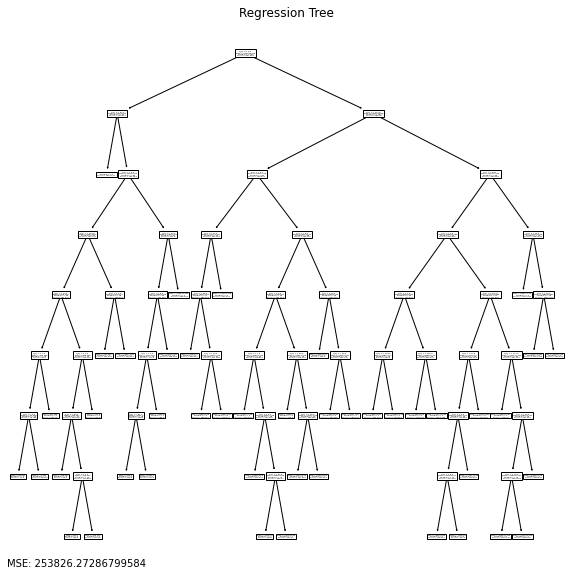

In [54]:
y2 = hitters[["Salary"]]
X2 = hitters[["Hits", "Years","HmRun"]]
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.05, random_state=0)
hitTreeDeep = tree.DecisionTreeRegressor(max_depth=10,min_samples_split=10,min_samples_leaf=0.01)
hitTreeDeep.fit(X=X2_train, y=y2_train)
y2_pred= hitTreeDeep.predict(X2_test)

# Grafico Tree + MSE
plt.rcParams['figure.figsize'] = 10,10
plt.figure()
tree.plot_tree(hitTreeDeep)
plt.title("Regression Tree")
plt.annotate(text='MSE: '+str(mean_squared_error(y2_test, y2_pred)), xy=(0,0))
plt.show()

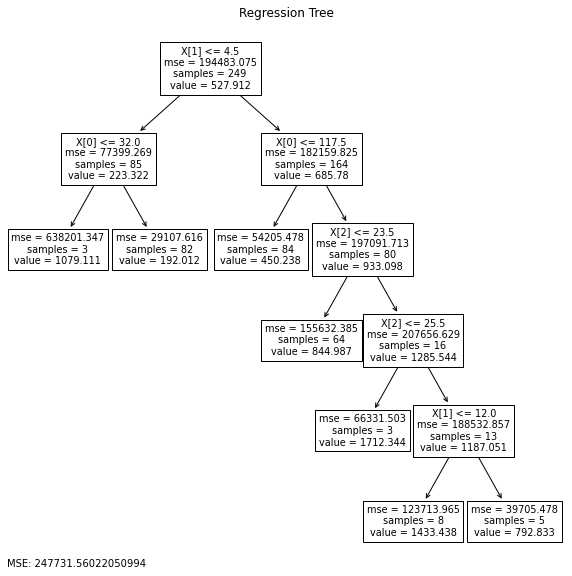

In [55]:
# Utilizando cost complexity pruning
hitTreeDeep = tree.DecisionTreeRegressor(max_depth=10,min_samples_split=10,min_samples_leaf=0.01,ccp_alpha=3500)
hitTreeDeep.fit(X=X2_train, y=y2_train)
y2_pred= hitTreeDeep.predict(X2_test)

# Grafico Tree + MSE
plt.rcParams['figure.figsize'] = 10,10
plt.figure()
tree.plot_tree(hitTreeDeep)
plt.title("Regression Tree")
plt.annotate(text='MSE: '+str(mean_squared_error(y2_test, y2_pred)), xy=(0,0))
plt.show()


## Bagging: Bootstrap aggregation

O bagging é outra maneira de atenuar a alta variância das árvores de decisão. A técnica consiste em treinar múltiplas árvores a partir de amostras bootstrap do dataset original, formando um comitê de modelos. Seja $M$ um número fixo de estimadores,

1. Realize uma amostra com reposição da amostra original, $(y^*,X^*)$.
2. Ajuste o modelo com base em $(y^*,X^*)$.
3. Repita os passos 1-2 até obter $M$ estimadores.

Seja $M$ o número de modelos treinados, o estimador obtido é da seguinte forma,

$$
\hat{T}(x) = \frac{1}{M}\sum_{i=1}^M T_{i}(x)
$$

Um termo comum utilizado na literatura de boostrap é out-of-bag, as observações que ficaram de fora durante a amostragem por bootstrap e podem ser utilizadas como teste para um subconjunto de árvores do bagging.

L. Breiman, “Bagging predictors”, Machine Learning, 24(2), 123-140, 1996.

![OOB](C:/Users/sergi/OOB_Error.png)

In [58]:
# O argumento random_state é muito importante, ele é a seed das simulações e é necessário para a 
# reproducibilidade dos seus resultados.

regr = BaggingRegressor(base_estimator=DecisionTreeRegressor(),
                        n_estimators=10, random_state=0).fit(X2_train, y2_train)
y2_pred = regr.predict(X2_test)
mean_squared_error(y2_test, y2_pred)

C:\Users\sergi\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


205079.0244623543

## Random Forests

As florestas aleatórias são uma extensão do bagging criado por Leo Breiman, um estatístico da UC-Berkeley. 

As RFs adicionam um passo extra ao bagging. O algoritmo sorteia um subconjunto de covariáveis para ser usado no ajuste das árvores, fazendo com que elas se tornem menos correlacionas.

Exemplo: Uma amostra com um divisor muito forte e vários outros de poder médio. O divisor forte vai aparecer com frequência excessiva, fazendo com que as árvores seja similares. Caso amostrarmos as covariáveis a cada passo, podemos atenuar a predominância dessa covariável e gerar árvores que extraem a informação restante nas outras variáveis.

## Boosting

O boosting é uma forma de obter um comitê de modelos baseado no ajuste de uma sequência de modelos simples denominados weak learners sobre a mesma amostra, porém as observações recebem pesos que variam a cada iteração.

1. Ajuste o estimador fraco.
2. Cheque onde os residuos sao maiores.
3. Aumente o peso das observacoes com base no tamanho dos residuos.
4. Reinicie o processo.

In [61]:
from sklearn.ensemble import GradientBoostingRegressor
regr = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100).fit(X2_train, y2_train)
y2_pred = regr.predict(X2_test)
mean_squared_error(y2_test, y2_pred)

C:\Users\sergi\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


199903.3013157327